# Computer Vision - Assignment 3

## 4. Rectify the pairs of images and with these new images, repeat steps 1 to 3

In [158]:
import cv2
import numpy as np
from skimage import filters
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.util.shape import view_as_blocks
from scipy.spatial.distance import cdist
from scipy.ndimage.filters import convolve
from skimage.feature import corner_peaks
from scipy import signal
%matplotlib inline
plt.rcParams['figure.figsize'] = (18.0, 12.0)  # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

**Helper functions**

In [159]:

def getColorSpaces(image):  
    rgb = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)  
    
    return rgb,gray
    
def getImageDimnesion(image):    
    height,width = image.shape[:2]
    
    return height,width

def showImage(image,title):    
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.title(title)
      
def getSubImage(img,left,right,top,bottom):
    
    return img[top:bottom, left:right].astype(np.float32)

**Functions to find Fundamental Matrix , Epipolar Lines and Points**

In [160]:
def drawlines(imgL,imgR,lines,ptsL,ptsR):
    ''' imgL - image on which we draw the epilines for the points in imgR
        lines - corresponding epilines '''
    r,c = imgL.shape[:2]

    num_points=80
    for r,pt1,pt2 in zip(lines[:num_points],ptsL[:num_points],ptsR[:num_points]):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        imgL = cv2.line(imgL, (x0,y0), (x1,y1), color,1)
        imgL = cv2.circle(imgL,tuple(pt1),12,color,5)
        imgR = cv2.circle(imgR,tuple(pt2),12,color,5)
    return imgL,imgR

def getFundamentalMatrix(ptsL,ptsR):
    F, mask = cv2.findFundamentalMat(ptsL,ptsR,cv2.FM_LMEDS)
    
    return F,mask

def getGoodMatchingPoints(grayL,grayR):
    
 #   sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
#    kp1, des1 = sift.detectAndCompute(grayL,None)
#    kp2, des2 = sift.detectAndCompute(grayR,None)
    
    # Initiate SURF detector
    surf = cv2.xfeatures2d.SURF_create(6000)
    kp1, des1 = surf.detectAndCompute(grayL,None)
    kp2, des2 = surf.detectAndCompute(grayR,None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    good_List=[]
    ptsL = []
    ptsR = []
    
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            good_List.append([m])
            ptsR.append(kp2[m.trainIdx].pt)
            ptsL.append(kp1[m.queryIdx].pt)
            
    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)

    matches = cv2.drawMatchesKnn(imgL,kp1,imgR,kp2,good_List,None,flags=2)
    plt.figure(figsize=(8,8))
    showImage(matches,'Matches for Stereo pair')
    plt.show()

    return ptsL,ptsR,good_List

def findEpipolarLines(rgbL,ptsL,rgbR,ptsR,F):
    
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    # Given a point in left camera x, epipolar line in right camera is given by
    # u=Fx ,where u is line
    
    rgbL_local=rgbL.copy()
    rgbR_local=rgbR.copy()
    
    
    # We select only inlier points
    ptsL = ptsL[mask.ravel()==1]
    ptsR = ptsR[mask.ravel()==1]  
    
    print('Computing Left Epipolar lines')
    epipolarlinesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2), 2,F)
    epipolarlinesLL=epipolarlinesL.copy()
    epipolarlinesL = epipolarlinesL.reshape(-1,3)
    img_epipolarlinesL,img_pointsR = drawlines(rgbL_local,rgbR_local,epipolarlinesL,ptsL,ptsR)
    
    print('Computing Right Epipolar lines')
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    epipolarlinesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1,F)
    epipolarlinesRR=epipolarlinesR.copy()
    epipolarlinesR = epipolarlinesR.reshape(-1,3)
    img_epipolarlinesR,img_pointsL = drawlines(rgbL_local,rgbR_local,epipolarlinesR,ptsR,ptsL)
    
  #Display the images
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    showImage(img_epipolarlinesL,'Left Epipolar Lines')
    plt.subplot(1,2,2)
    showImage(img_epipolarlinesR,'Right Epipolar Lines')
    plt.show()
    
    return ptsL,epipolarlinesLL,ptsR,epipolarlinesRR

**Functions for rectifying image**

In [161]:
def homogenous2Euclidean(x):
    if hasattr(x, 'shape') and len(x.shape) > 1:
        valid = x[-1,:] != 0
        result = np.empty((x.shape[0]-1, x.shape[1]), dtype=float)
        result[:,valid] = x[:-1,valid] / x[-1, valid]
        result[:,~valid] = np.nan
        return result
    else:
        if x[-1] == 0:
            result = np.empty(len(x)-1, dtype=float)
            result[:] = np.nan
            return result
        else:
            return np.array(x[:-1]) / x[-1]
        
def rectifyShearing(H1, H2, imsize):
    w = imsize[0]
    h = imsize[1]

    a = ((w-1)/2., 0., 1.)
    b = (w-1., (h-1.)/2., 1.)
    c = ((w-1.)/2., h-1., 1.)
    d = (0., (h-1.)/2., 1.)

    ap = homogenous2Euclidean(H1.dot(a))
    bp = homogenous2Euclidean(H1.dot(b))
    cp = homogenous2Euclidean(H1.dot(c))
    dp = homogenous2Euclidean(H1.dot(d))

    x = bp - dp
    y = cp - ap

    k1 = (h*h*x[1]*x[1] + w*w*y[1]*y[1]) / (h*w*(x[1]*y[0] - x[0]*y[1]))
    k2 = (h*h*x[0]*x[1] + w*w*y[0]*y[1]) / (h*w*(x[0]*y[1] - x[1]*y[0]))

    if k1 < 0:
        k1 *= -1
        k2 *= -1

    return np.array([[k1, k2, 0],
                     [0, 1, 0],
                     [0, 0, 1]], dtype=float)


def unDistortMap(H1, H2, img1, img2):
    
    imgsize = (imgL.shape[1], imgL.shape[0])    
    K = np.array([[50, 0, 20], [0, 50, 30], [0, 0, 1]]) 
    d = None # Assume no distortion
   
    rH = np.linalg.inv(K).dot(H1).dot(K)
    lH = np.linalg.inv(K).dot(H2).dot(K)
    
    map1x, map1y = cv2.initUndistortRectifyMap(K, d, rH, K, imgsize,cv2.CV_16SC2)
    map2x, map2y = cv2.initUndistortRectifyMap(K, d, lH, K, imgsize, cv2.CV_16SC2)

    return img1, map1x, map1y, img2, map2x, map2y

def getRemap(img1, map1x, map1y, img2, map2x, map2y):

    rimg1 = cv2.remap(img1, map1x, map1y,
                      interpolation=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_CONSTANT,
                      borderValue=(0,0,0,0))
    rimg2 = cv2.remap(img2, map2x, map2y,
                      interpolation=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_CONSTANT,
                      borderValue=(0,0,0,0))
        
    return rimg1, rimg2
     
def getRectifiedImages(imgL, imgR, lines1, lines2, pts1, pts2, F):
    h,w=getImageDimnesion(imgL)
    imgsize = (h,w)
    
    # transpose
    pts1 = pts1.T
    pts2 = pts2.T

    _, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, imgsize)

    S = rectifyShearing(H1, H2, imgsize)
    H1 = S.dot(H1)
    
    #print(H1)

    img1, map1x, map1y, img2, map2x, map2y = unDistortMap(H1, H2, imgL, imgR)

    rimg1, rimg2 = getRemap(img1, map1x, map1y, img2, map2x, map2y)
    
    return rimg1, rimg2

In [162]:
# Read the images
img = cv2.imread(r'Stereo Images\Stereo_Pair1.jpg')

height,width = img.shape[:2]
width_cutoff = width // 2
imgL = img[:, :width_cutoff]
imgR = img[:, width_cutoff:]

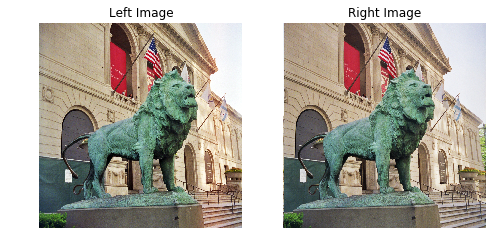

In [163]:
#imgL=cv2.imread(r'Stereo Images\tsucuba_left.png')
#imgR=cv2.imread(r'Stereo Images\tsucuba_right.png')
rgbL,grayL=getColorSpaces(imgL)
rgbR,grayR=getColorSpaces(imgR)

#Display the images
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
showImage(rgbL,'Left Image')
plt.subplot(1,2,2)
showImage(rgbR,'Right Image')
plt.show()

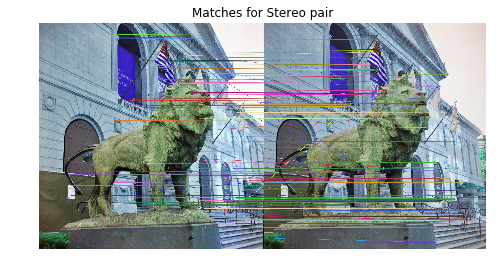

Fundamental Matrix
[[ 3.37497919e-08 -1.51122521e-05  7.21996082e-03]
 [ 1.40896417e-05  1.01397230e-06  1.83199147e-01]
 [-6.30588292e-03 -1.85436428e-01  1.00000000e+00]]


In [164]:
# Now we can match the keypoints
ptsL, ptsR, good_List = getGoodMatchingPoints(grayL,grayR)

# Compute the Fundamental matrix
F, mask = cv2.findFundamentalMat(ptsL, ptsR,cv2.FM_LMEDS)

print("Fundamental Matrix")
print(F)

Computing Left Epipolar lines
Computing Right Epipolar lines


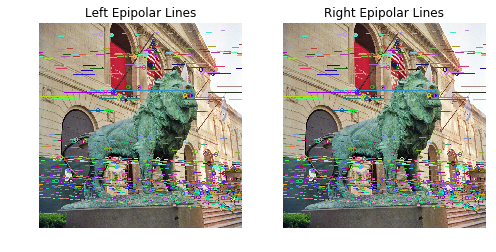

In [165]:
ptsL,epipolarlinesL,ptsR,epipolarlinesR=findEpipolarLines(rgbL,ptsL,rgbR,ptsR,F)
rimgL, rimgR = getRectifiedImages(grayL, grayR, epipolarlinesL, epipolarlinesR, ptsL, ptsR, F)

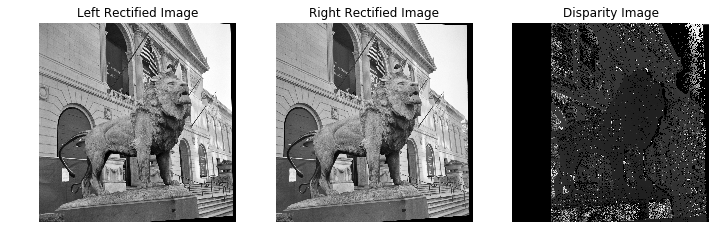

In [169]:
plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
showImage(rimgL,'Left Rectified Image')
plt.subplot(1,3,2)
showImage(rimgR,'Right Rectified Image')


cv2.imwrite('rect_left.png',rimgL)
cv2.imwrite('rect_right.png',rimgR)

##for i in range(5,15,2):

stereo = cv2.StereoSGBM_create(minDisparity=16, numDisparities=16*16, blockSize=5)  
disparity = stereo.compute(rimgL,rimgR)
plt.subplot(1,3,3)
showImage(disparity,'Disparity Image')
plt.show()


